# Contextualized Models And Outlier Robustness

Contextualized models allow the effect (output) to change as the context changes. Therefore, they should be robust when dealing with outliers, where the context differs from 'normal' samples. 

In this notebook, we will assess the robustness of contextualized models when faced with outliers. We'll begin by training the models using data that **doesn't** include any outliers, and then we'll proceed to include outlier data to observe how well the models maintain their performance.

## Data Preparation

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from contextualized.easy import ContextualizedRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import logging
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

### Preparing non outlier data

In [2]:
X_normal, Y_normal = load_diabetes(return_X_y=True, as_frame=True)
Y_normal = np.expand_dims(Y_normal.values, axis=-1)
C_normal = X_normal[['age', 'sex', 'bmi']]
X_normal.drop(['age', 'sex', 'bmi'], axis=1, inplace=True)

seed = 1
C_train_normal, C_test_normal, X_train_normal, X_test_normal, Y_train_normal, Y_test_normal = train_test_split(C_normal, X_normal, Y_normal, test_size=0.20, random_state=seed)

### Preparing outlier data

To simulate a localized outlier effect, we corrupt the data in a region of context.

In [3]:
X_outlier, Y_outlier = load_diabetes(return_X_y=True, as_frame=True)
Y_outlier = np.expand_dims(Y_outlier.values, axis=-1)
C_outlier = X_outlier[['age', 'sex', 'bmi']]
X_outlier.drop(['age', 'sex', 'bmi'], axis=1, inplace=True)

seed = 1
C_train_outlier, C_test_outlier, X_train_outlier, X_test_outlier, Y_train_outlier, Y_test_outlier = train_test_split(C_outlier, X_outlier, Y_outlier, test_size=0.20, random_state=seed)

# find 40 nearest neighbors in C_train_outlier to modify output values
knn_model = NearestNeighbors(n_neighbors=40)
knn_model.fit(C_train_outlier)

query_value = C_train_outlier.iloc[0:1] # this value is what the model will find the nearest neighbors to
distances, indices = knn_model.kneighbors(query_value)
neighbor_indices = indices.flatten()

# modifying values at indices
outlier_values = np.random.uniform(0, 1000, size=(len(neighbor_indices), Y_train_outlier.shape[1]))
Y_train_outlier[neighbor_indices] = outlier_values


### Training models (non-outlier data)

#### Training & testing a contextualized regressor with non outlier data

In [4]:
%%capture
context_regressor = ContextualizedRegressor(n_bootstraps=10)
context_regressor.fit(C_train_normal.values, X_train_normal.values, Y_train_normal,
          encoder_type="mlp", max_epochs=3,
          learning_rate=1e-2)

context_pred_normal = context_regressor.predict(C_test_normal.values, X_test_normal.values)[:, 0]

#### Training & testing an sklearn regressor with non outlier data

In [5]:
# Combine C and X training data and testing data (only for sklearn model)
sk_train_normal = pd.concat([C_train_normal, X_train_normal], axis=1)
sk_test_normal = pd.concat([C_test_normal, X_test_normal], axis=1)

# Initialize and train a linear regression model
sklearn_regressor = LinearRegression()
sklearn_regressor.fit(sk_train_normal, Y_train_normal)

# Make predictions on the test set
sklearn_pred_normal = sklearn_regressor.predict(sk_test_normal)
sklearn_pred_normal = sklearn_pred_normal.reshape(-1)

#### Plotting predictions (non outlier data)

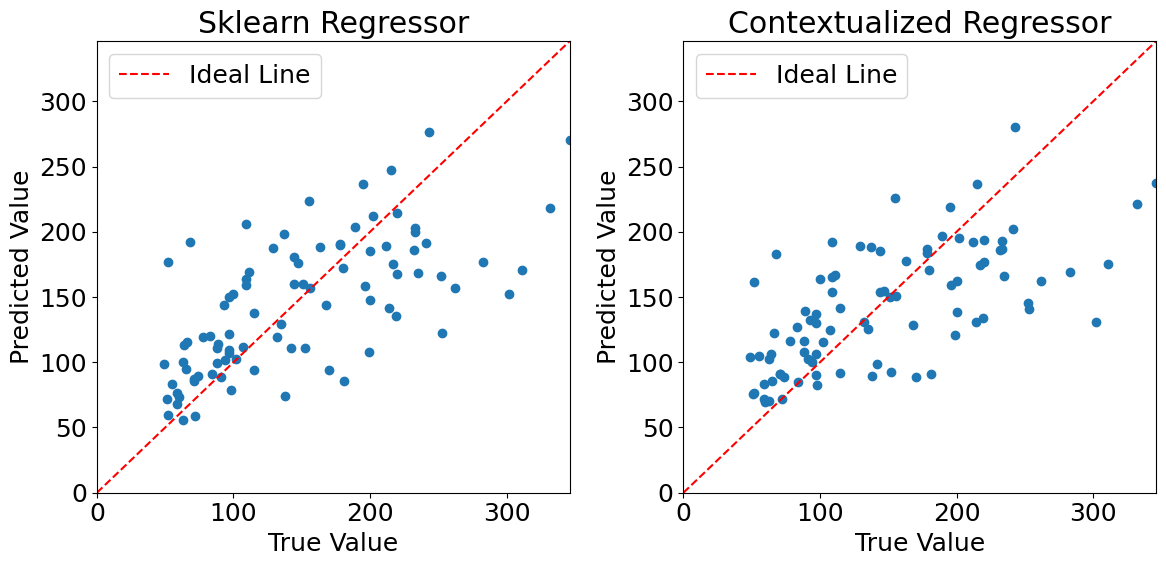

In [6]:
%matplotlib inline
plt.rcParams.update({'font.size': 18})

# Get the maximum value of the true values to set the same limit for both subplots
max_true_value = max(Y_test_normal[:, 0])

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first graph in the first subplot
axes[0].scatter(Y_test_normal[:, 0], sklearn_pred_normal)
axes[0].set_xlabel("True Value")
axes[0].set_ylabel("Predicted Value")
axes[0].set_title("Sklearn Regressor")
axes[0].set_xlim(0, max_true_value)
axes[0].set_ylim(0, max_true_value)
axes[0].plot([0, max_true_value], [0, max_true_value], color='red', linestyle='--', label='Ideal Line')
axes[0].legend()  # Display the legend

# Plot the second graph in the second subplot
axes[1].scatter(Y_test_normal[:, 0], context_pred_normal)
axes[1].set_xlabel("True Value")
axes[1].set_ylabel("Predicted Value")
axes[1].set_title("Contextualized Regressor")
axes[1].set_xlim(0, max_true_value)
axes[1].set_ylim(0, max_true_value)
axes[1].plot([0, max_true_value], [0, max_true_value], color='red', linestyle='--', label='Ideal Line')
axes[1].legend()  # Display the legend

plt.tight_layout()
plt.show()

#### Evaluating model performances

##### Calculating mean squared error

In [7]:
mse_sklearn_normal = mean_squared_error(Y_test_normal[:, 0], sklearn_pred_normal)
mse_contextualized_normal = mean_squared_error(Y_test_normal[:, 0], context_pred_normal)

print("Mean Squared Error (sklearn regressor):", mse_sklearn_normal)
print("Mean Squared Error (contextualized regressor):", mse_contextualized_normal)

Mean Squared Error (sklearn regressor): 2992.5812293010176
Mean Squared Error (contextualized regressor): 3096.8795401426196


##### Plotting distance from query value vs. percentage error

In [8]:
# getting distances for each point in the normal class
distances = np.linalg.norm(C_test_normal - query_value.values, axis=1)

In [9]:
# Calculate percentage errors for sklearn model
errors_sklearn_normal = [(abs(true - pred) / true) * 100 for true, pred in zip(Y_test_normal[:, 0], sklearn_pred_normal)]

# Calculate percentage errors for contextualized model
errors_context_normal = [(abs(true - pred) / true) * 100 for true, pred in zip(Y_test_normal[:, 0], context_pred_normal)]


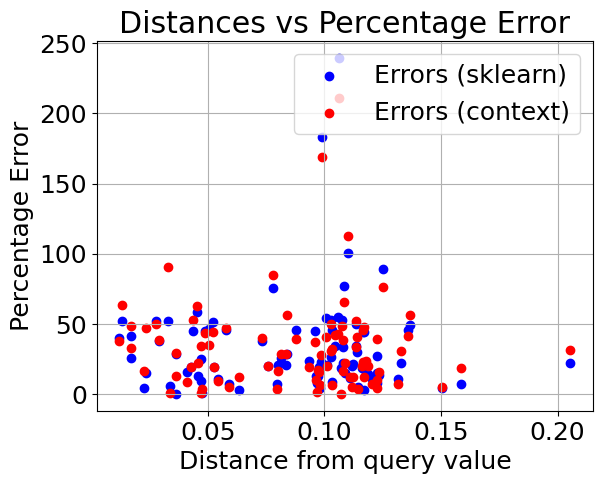

In [10]:
plt.scatter(distances, errors_sklearn_normal, color='blue', marker='o', label='Errors (sklearn)')
plt.scatter(distances, errors_context_normal, color='red', marker='o', label='Errors (context)')

plt.title('Distances vs Percentage Error')
plt.xlabel('Distance from query value')
plt.ylabel('Percentage Error')
plt.legend()
plt.grid(True)
plt.show()

We can see that the models perform very similarly on the non outlier data. Now lets introduce outliers in the dataset and see how they hold up. We have modified the dataset to contain 40 outliers.

### Training models (outlier data)

#### Training & testing a contextualized regressor with outlier data

In [11]:
%%capture
context_regressor = ContextualizedRegressor(n_bootstraps=10)
context_regressor.fit(C_train_outlier.values, X_train_outlier.values, Y_train_outlier,
          encoder_type="mlp", max_epochs=3,
          learning_rate=1e-2)

context_pred_outlier = context_regressor.predict(C_test_normal.values, X_test_normal.values)[:, 0]

#### Training & testing an sklearn regressor with outlier data

In [12]:
# Combine C and X training data and testing data (only for sklearn model)
sk_train_outlier = pd.concat([C_train_outlier, X_train_outlier], axis=1)
sk_test_outlier = pd.concat([C_test_normal, X_test_normal], axis=1)

# Initialize and train a linear regression model
sklearn_regressor = LinearRegression()
sklearn_regressor.fit(sk_train_outlier, Y_train_outlier)

# Make predictions on the test set
sklearn_pred_outlier = sklearn_regressor.predict(sk_test_outlier)
sklearn_pred_outlier = sklearn_pred_outlier.reshape(-1)

#### Plotting predictions (outlier data)

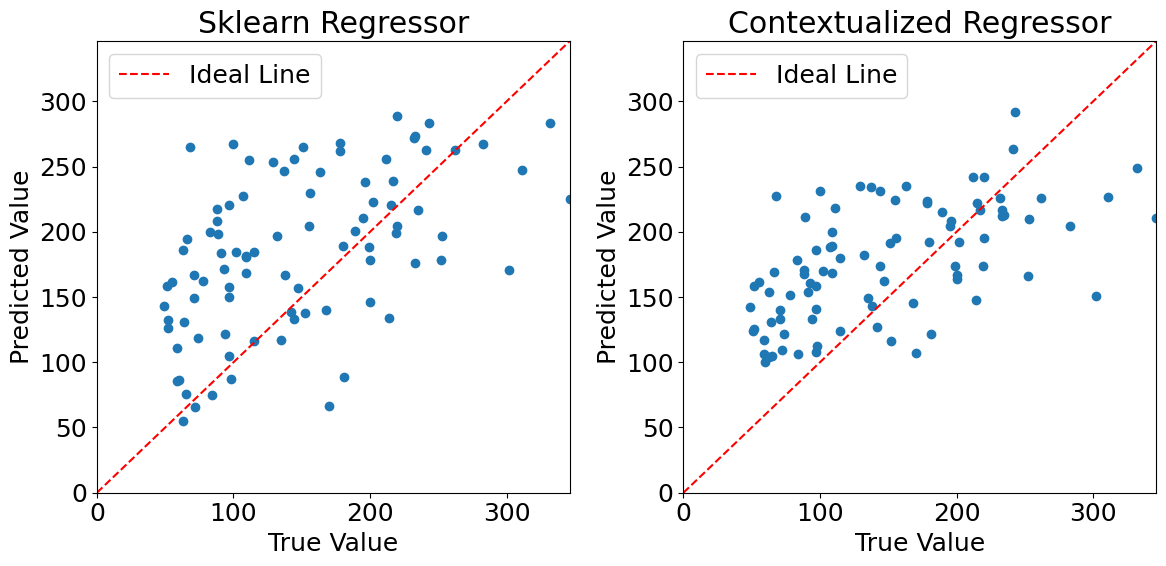

In [13]:
%matplotlib inline
plt.rcParams.update({'font.size': 18})

# Get the maximum value of the true values to set the same limit for both subplots
max_true_value = max(Y_test_normal[:, 0])

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first graph
axes[0].scatter(Y_test_normal[:, 0], sklearn_pred_outlier)
axes[0].set_xlabel("True Value")
axes[0].set_ylabel("Predicted Value")
axes[0].set_title("Sklearn Regressor")
axes[0].set_xlim(0, max_true_value)
axes[0].set_ylim(0, max_true_value)
axes[0].plot([0, max_true_value], [0, max_true_value], color='red', linestyle='--', label='Ideal Line')
axes[0].legend()

# Plot the second graph
axes[1].scatter(Y_test_normal[:, 0], context_pred_outlier)
axes[1].set_xlabel("True Value")
axes[1].set_ylabel("Predicted Value")
axes[1].set_title("Contextualized Regressor")
axes[1].set_xlim(0, max_true_value)
axes[1].set_ylim(0, max_true_value)
axes[1].plot([0, max_true_value], [0, max_true_value], color='red', linestyle='--', label='Ideal Line')
axes[1].legend()

plt.tight_layout()
plt.show()

#### Evaluating model performances

##### Calculating mean squared error

In [14]:
mse_sklearn_normal = mean_squared_error(Y_test_normal[:, 0], sklearn_pred_outlier)
mse_contextualized_normal = mean_squared_error(Y_test_normal[:, 0], context_pred_outlier)

print("Mean Squared Error (sklearn regressor):", mse_sklearn_normal)
print("Mean Squared Error (contextualized regressor):", mse_contextualized_normal)

Mean Squared Error (sklearn regressor): 5796.912311772902
Mean Squared Error (contextualized regressor): 4391.024436984243


##### Plotting distance from query value vs. percentage error

In [15]:
# Calculate percentage errors for sklearn model
errors_sklearn_outlier = [(abs(true - pred) / true) * 100 for true, pred in zip(Y_test_normal[:, 0], sklearn_pred_outlier)]

# Calculate percentage errors for contextualized model
errors_context_outlier = [(abs(true - pred) / true) * 100 for true, pred in zip(Y_test_normal[:, 0], context_pred_outlier)]


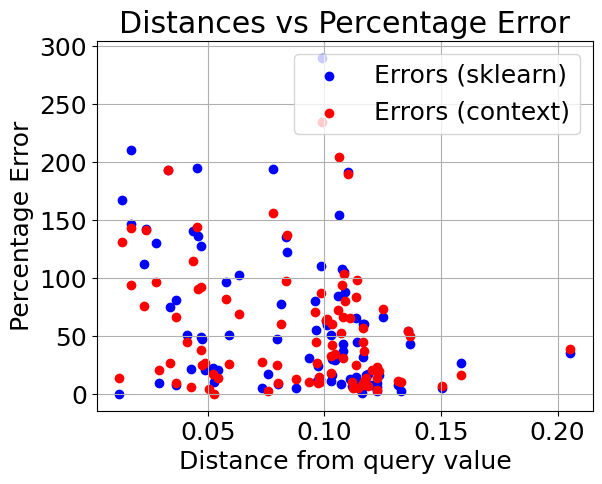

In [16]:
plt.scatter(distances, errors_sklearn_outlier, color='blue', marker='o', label='Errors (sklearn)')
plt.scatter(distances, errors_context_outlier, color='red', marker='o', label='Errors (context)')

plt.title('Distances vs Percentage Error')
plt.xlabel('Distance from query value')
plt.ylabel('Percentage Error')
plt.legend()
plt.grid(True)
plt.show()

##### Normalizing errors with respect to sklearn percentage error (for clarity)

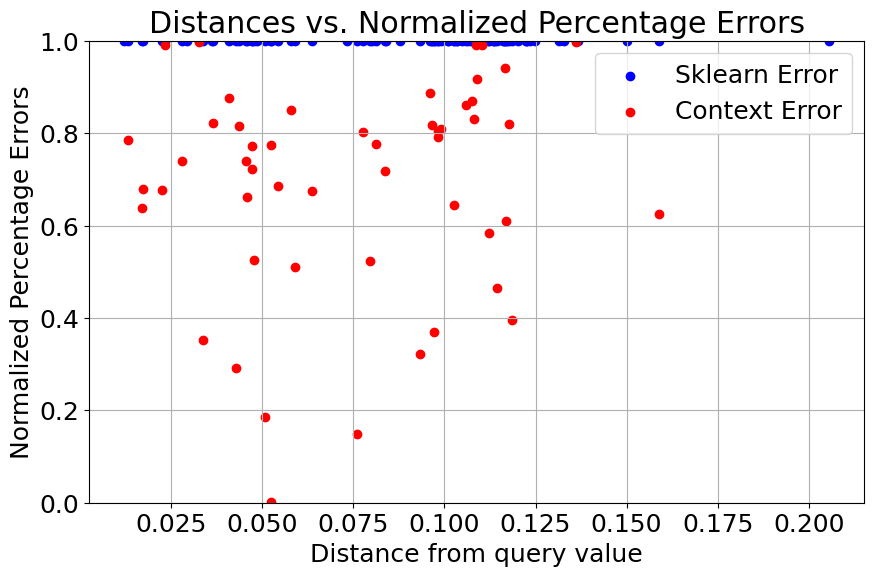

In [17]:
normalized_errors_sklearn_outlier = np.array(errors_sklearn_outlier) / np.array(errors_sklearn_outlier)
normalized_errors_context_outlier = np.array(errors_context_outlier) / np.array(errors_sklearn_outlier)

plt.figure(figsize=(10, 6))
plt.scatter(distances, normalized_errors_sklearn_outlier, label='Sklearn Error', color='blue')
plt.scatter(distances, normalized_errors_context_outlier, label='Context Error', color='red')
plt.xlabel('Distance from query value')
plt.ylabel('Normalized Percentage Errors')
plt.title('Distances vs. Normalized Percentage Errors')
plt.legend()
plt.grid(True)

plt.ylim(0, 1)
plt.show()

After injecting outliers into the training data, we can see that the performance of the sklearn regressor quickly degrades when compared to the contextualized regressor.